# Capstone Exercise

In this exercise I will read canadian postcodes from wiki page, enrich with latitude and longitude, clustering those postal codes based on Foursquares recommended places and map them graphically

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. <a href="#item1">Reading Canadian Postcodes from wiki page</a>

2. <a href="#item2">Enrich information with Latitude and Longitude</a>

3. <a href="#item3">Enrich information with Foursquare data regarding recommended places in the Postal Zone</a>

4. <a href="#item4">Analyze each Postal Zone</a>

5. <a href="#item5">Analyze each Postal Zone</a>    
    
6. <a href="#item6">Toronto Map with Clustered Postal Zones</a>
</font>
</div>

<a id=item1></a>
## 1. Reading canadian postcodes from wiki page
In this part I will cover the following steps:
1. Import required resources, 
2. Read list of postal zones for Toronto
3. Do some data cleansing 

### 1.1 Install and import the required resources
**Note:** If geocoder, geopy, or folium has not been previously installed, uncomment the three first lines. 

In [1]:
#!conda install -c conda-forge geocoder -y
#!conda install -c conda-forge geopy --yes 
#!conda install -c conda-forge folium=0.5.0 --yes

import pandas as pd
import geocoder
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np
import folium # map rendering library

### 1.2 Import Toronto Postal codes
After exploring the required internet page, we see that the required table is the first table in the page. Pandas read_html returns a list of dataframes with each table on the page converted on a dataframe. Our objective dataframe is the first in the list:

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
df_list = pd.read_html(url)
post_codes = df_list[0]
post_codes.head(10)

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights
7,M6A,North York,Lawrence Manor
8,M7A,Queen's Park,Not assigned
9,M8A,Not assigned,Not assigned


### 1.3 Data Cleansing and preparation
Now, lets do some transformations:
1. get rid of rows with not assigned borough
2. rename neighbourhood when borough is assigned and neighbourhood not.
3. combine neighbourhoods that belongs to the same postcode

In [33]:
# drop post codes without Borough
post_codes.drop(post_codes[post_codes.Borough=='Not assigned'].index, inplace=True)

# rename neighbourhood where borough is assigned but neighbourhood name is not provided
post_codes.Neighbourhood.where((~post_codes.Neighbourhood.eq('Not assigned')), post_codes.Borough, inplace=True)

#group by postcodes, concatenating neighbourhood names
final_post_codes = pd.DataFrame(post_codes.groupby(['Postcode', 'Borough'])['Neighbourhood'].apply(lambda x: ', '.join(x))).reset_index()

#printing 10 rows to check the result.
final_post_codes.head(10)

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park"
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge"
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


In [4]:
final_post_codes.shape

(103, 3)

<a id=item2></a>
## 2. Enrich information with Latitude and Longitude
I tried geocoder.google, but it requires to instantiate a service in google, ogherwise, it returns error "<[REQUEST_DENIED] Google - Geocode [empty]>".  I also tried Nominatim, but Nominatim does not recognize search text with only the first three characters of the postal code, so I decided to load the provided prepared data 

In [34]:
# read latitude and longitude for toronto postal code
toronto_pc = pd.read_csv("http://cocl.us/Geospatial_data")

# merge geospatial data with prepared postal codes information
toronto_data = pd.merge(left=final_post_codes, right=toronto_pc, left_on='Postcode', right_on='Postal Code')

# present 10 rows to check the partial result
toronto_data.head(10)

,Postcode,Borough,Neighbourhood,Postal Code,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",M1B,43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",M1C,43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",M1E,43.763573,-79.188711
3,M1G,Scarborough,Woburn,M1G,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,M1H,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,M1J,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",M1K,43.727929,-79.262029
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",M1L,43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",M1M,43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",M1N,43.692657,-79.264848


# Second Part: Analyzing information for Postal Zones in Toronto

<a id=item3></a>
## 3 Enrich information with Foursquare data regarding recommended places in the Postal Zone
* get vuenues trending, to identify venues being tendency in the zone
* exploring the venues categories (or venues details?), to understand the trending categories in the zone
* explore 

There are other potential source of information that I will not be presenting in this work given personal limitation of time:
* https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/hlt-fst/pd-pl/Table.cfm?Lang=Eng&T=1201&S=22&O=A

* http://data.torontopolice.on.ca/datasets/98f7dde610b54b9081dfca80be453ac9_0/data

In [9]:
# @hidden_cell
# Prepare some constants to be used recovering information with Foursquare
CLIENT_ID = 'PINJLTKA2NPIJNNAE4T2UBX1BP5HOTQKYBC41Y2XYXJIYRAO' # your Foursquare ID
CLIENT_SECRET = 'ULHL0GUB4MK1VBX05VAUQIC12ZB2XAGZP11SQUD4QCM3CEFC' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET: ' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: PINJLTKA2NPIJNNAE4T2UBX1BP5HOTQKYBC41Y2XYXJIYRAO
CLIENT_SECRET: ULHL0GUB4MK1VBX05VAUQIC12ZB2XAGZP11SQUD4QCM3CEFC


Let's define a function to extract categories from venues

In [10]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

... and a function that gets the near-by venues for a given coordinates...  
One potential improvement is to search based on the polygon for the postal zone, instead of the centroid and radius, but that requires to find polygon information for each postal zone in Toronto. 

In [11]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, limit=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()
        venues = results['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venues])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Postal Zone', 
                  'Postal Zone Latitude', 
                  'Postal Zone Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now write the code to run the above function on each postal zone and create a new dataframe called toronto_venues.¶

In [15]:
toronto_venues = getNearbyVenues(names=toronto_data['Postcode'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

M1B
M1C
M1E
M1G
M1H
M1J
M1K
M1L
M1M
M1N
M1P
M1R
M1S
M1T
M1V
M1W
M1X
M2H
M2J
M2K
M2L
M2M
M2N
M2P
M2R
M3A
M3B
M3C
M3H
M3J
M3K
M3L
M3M
M3N
M4A
M4B
M4C
M4E
M4G
M4H
M4J
M4K
M4L
M4M
M4N
M4P
M4R
M4S
M4T
M4V
M4W
M4X
M4Y
M5A
M5B
M5C
M5E
M5G
M5H
M5J
M5K
M5L
M5M
M5N
M5P
M5R
M5S
M5T
M5V
M5W
M5X
M6A
M6B
M6C
M6E
M6G
M6H
M6J
M6K
M6L
M6M
M6N
M6P
M6R
M6S
M7A
M7R
M7Y
M8V
M8W
M8X
M8Y
M8Z
M9A
M9B
M9C
M9L
M9M
M9N
M9P
M9R
M9V
M9W


In [16]:
toronto_venues.head()

,Postal Zone,Postal Zone Latitude,Postal Zone Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M1B,43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,M1C,43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,M1C,43.784535,-79.160497,Scarborough Historical Society,43.788755,-79.162438,History Museum
3,M1E,43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place
4,M1E,43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store


How many venues per Postal Zone?

In [17]:
toronto_venues.groupby('Postal Zone').count()

,Postal Zone Latitude,Postal Zone Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Postal Zone,,,,,,
M1B,1,1,1,1,1,1
M1C,2,2,2,2,2,2
M1E,7,7,7,7,7,7
M1G,3,3,3,3,3,3
M1H,7,7,7,7,7,7
M1J,3,3,3,3,3,3
M1K,7,7,7,7,7,7
M1L,9,9,9,9,9,9
M1M,2,2,2,2,2,2


In [18]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 270 uniques categories.


<a id=item4></a>
## 4. Analyze each Postal Zone
To analyze each Postal Zone, first I encoded unique categories with the one-hot encoding technique.

In [19]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add Postal Zone column back to dataframe
toronto_onehot['Postal Zone'] = toronto_venues['Postal Zone'] 

# move Postal Zone column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Postal Zone,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,M1B,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,M1C,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,M1C,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,M1E,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,M1E,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Next, let's group rows by postal zone and by taking the mean of the frequency of occurrence of each category

In [20]:
toronto_grouped = toronto_onehot.groupby('Postal Zone').mean().reset_index()
toronto_grouped.head()

,Postal Zone,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,M1B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,M1C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,M1E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,M1G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,M1H,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<a id=item5></a>
## 5. Clustering Postal Zones

To determine the optimal number of cluster, I will run KMeans with different number of clusters between 2 and 10 and graphic the...

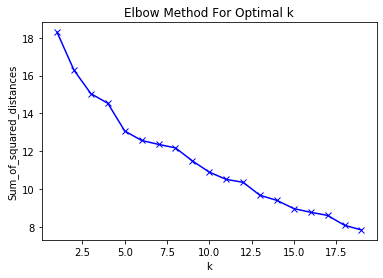

In [62]:
# Postal Zone column is dropped to proceed with the clustering algorithm
toronto_grouped_clustering = toronto_grouped.drop('Postal Zone', 1)

Sum_of_squared_distances = []
K = range(1,20)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(toronto_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

The elbow in the gap is around 11.  Let's check silhouettes for 5, 7, 10, and 11 to decide

For n_clusters = 5 The average silhouette_score is : 0.21819735269624008
For n_clusters = 7 The average silhouette_score is : 0.04187437171043724
For n_clusters = 10 The average silhouette_score is : 0.21698659252212568
For n_clusters = 11 The average silhouette_score is : 0.1039934856607418


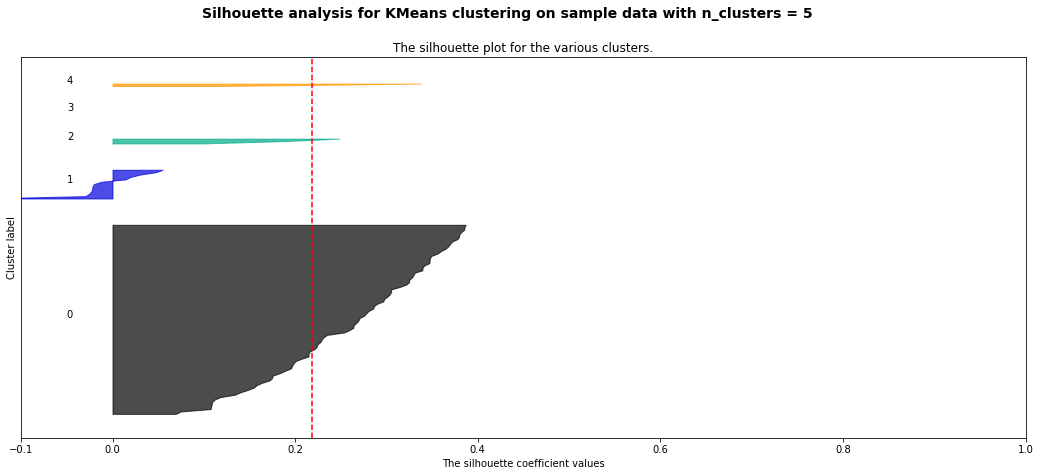

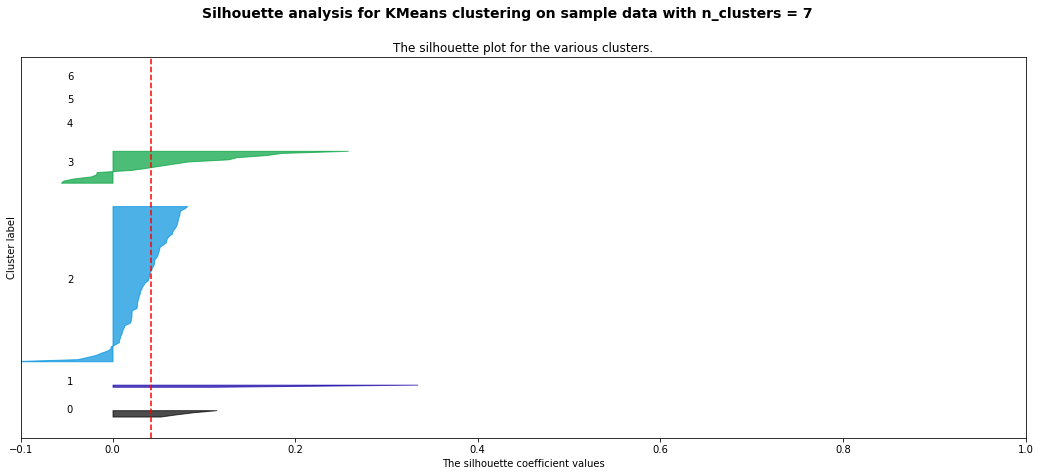

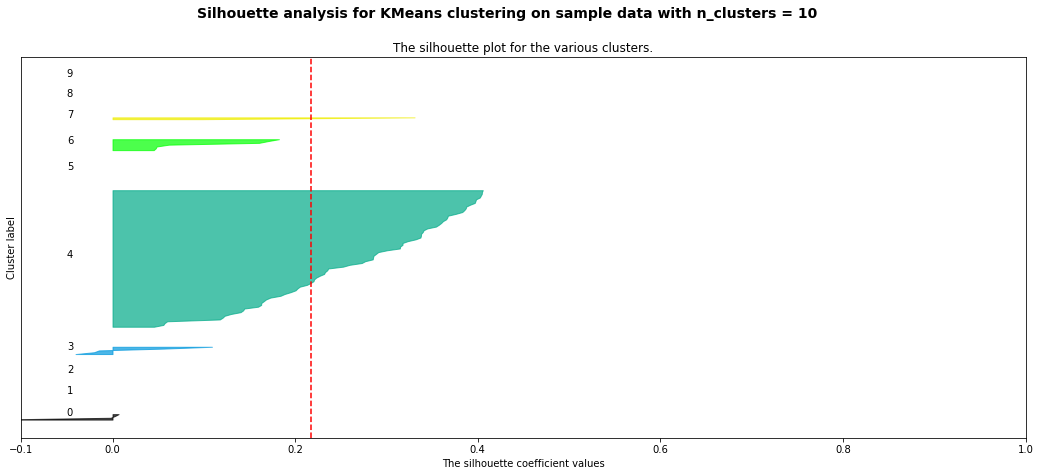

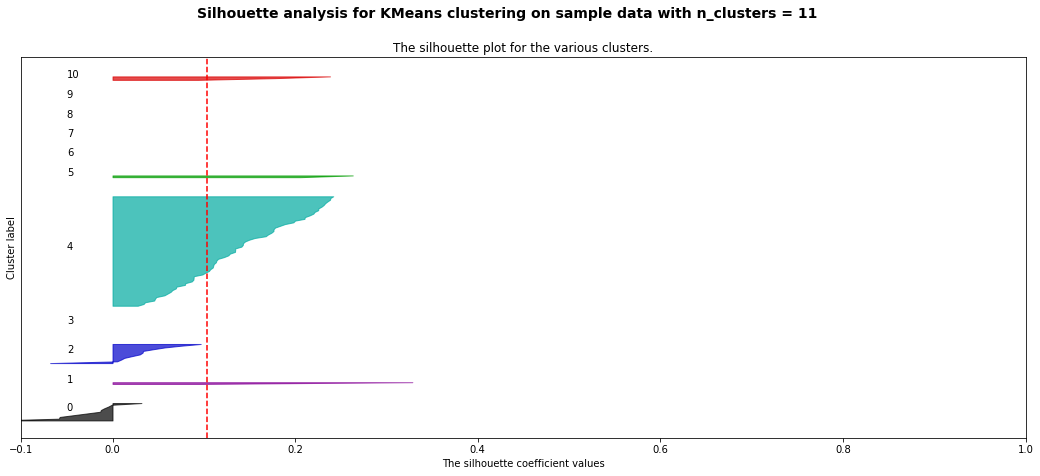

In [63]:
range_of_k = [5, 7, 10, 11]
for n_clusters in range_of_k:
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(toronto_grouped_clustering) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(toronto_grouped_clustering)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(toronto_grouped_clustering, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(toronto_grouped_clustering, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

None of the graph shows a very good silhouette graph... Let's say that we get the best clustering exercise with 7 clusters  
Now, lets merge toronto's data frame with clustering to graph postal zone's clustering

In [64]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [65]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Postal Zone']

for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Postal_Zones_venues_sorted = pd.DataFrame(columns=columns)
Postal_Zones_venues_sorted['Postal Zone'] = toronto_grouped['Postal Zone']

for ind in np.arange(toronto_grouped.shape[0]):
    Postal_Zones_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

Postal_Zones_venues_sorted.head()

,Postal Zone,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Fast Food Restaurant,Yoga Studio,Donut Shop,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Drugstore
1,M1C,Bar,History Museum,Yoga Studio,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop
2,M1E,Medical Center,Electronics Store,Pizza Place,Breakfast Spot,Mexican Restaurant,Rental Car Location,Intersection,Diner,Dessert Shop,Dim Sum Restaurant
3,M1G,Coffee Shop,Korean Restaurant,Yoga Studio,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Drugstore
4,M1H,Fried Chicken Joint,Bank,Hakka Restaurant,Caribbean Restaurant,Athletics & Sports,Thai Restaurant,Bakery,Discount Store,Dessert Shop,Dim Sum Restaurant


In [39]:
# set number of clusters
kclusters = 7

toronto_grouped_clustering = toronto_grouped.drop('Postal Zone', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# add clustering labels
Postal_Zones_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each Posta Zone
toronto_merged = toronto_merged.join(Postal_Zones_venues_sorted.set_index('Postal Zone'), on='Postcode')

toronto_merged.head() # check the last columns!

,Postcode,Borough,Neighbourhood,Postal Code,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",M1B,43.806686,-79.194353,4.0,Fast Food Restaurant,Yoga Studio,Donut Shop,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Drugstore
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",M1C,43.784535,-79.160497,4.0,Bar,History Museum,Yoga Studio,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",M1E,43.763573,-79.188711,0.0,Medical Center,Electronics Store,Pizza Place,Breakfast Spot,Mexican Restaurant,Rental Car Location,Intersection,Diner,Dessert Shop,Dim Sum Restaurant
3,M1G,Scarborough,Woburn,M1G,43.770992,-79.216917,4.0,Coffee Shop,Korean Restaurant,Yoga Studio,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Drugstore
4,M1H,Scarborough,Cedarbrae,M1H,43.773136,-79.239476,4.0,Fried Chicken Joint,Bank,Hakka Restaurant,Caribbean Restaurant,Athletics & Sports,Thai Restaurant,Bakery,Discount Store,Dessert Shop,Dim Sum Restaurant


<a id=item6></a>
## 6. Toronto Map with Clustered Postal Zones 
The following code creates a Toronto map with postal zones. Colors indicates the cluster to which each postal zone belongs to.

In [69]:
address = 'Toronto, Ontario, Canada'

geolocator = Nominatim(user_agent="toronto_explorer", timeout=10)
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of {} are {}, {}.'.format(address, latitude, longitude))

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)

ys = [i + x + (i*x)**2 for i in range(kclusters)]

colors_array = cm.rainbow(np.linspace(0, 1, len(ys)+1))

rainbow = [colors.rgb2hex(i) for i in colors_array]

toronto_merged['Cluster Labels']=toronto_merged['Cluster Labels'].fillna(len(rainbow))

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Postcode'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

The geograpical coordinate of Toronto, Ontario, Canada are 43.653963, -79.387207.
